### Урок3. Связь бизнес-показателей и DS-метрик

In [1]:
import pandas as pd


In [2]:
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score



In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix


In [4]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin


In [5]:
import seaborn as sns
import itertools
import matplotlib.pyplot as plt


В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [6]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [7]:
df['weight']

0         62.0
1         85.0
2         64.0
3         82.0
4         56.0
         ...  
69995     76.0
69996    126.0
69997    105.0
69998     72.0
69999     72.0
Name: weight, Length: 70000, dtype: float64

In [8]:
df["weight"]=df["weight"].astype('int64')

In [9]:
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62,110,80,1,1,0,0,1,0
1,1,20228,1,156,85,140,90,3,1,0,0,1,1
2,2,18857,1,165,64,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [10]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [11]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [12]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74852583, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29630093, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15699069, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15699069, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74852583, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08733558, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию

In [13]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7867378112860026+-0.008522153391103416


Посчитаем precision/recall/f_score

In [14]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.386942, F-Score=0.730, Precision=0.647, Recall=0.838


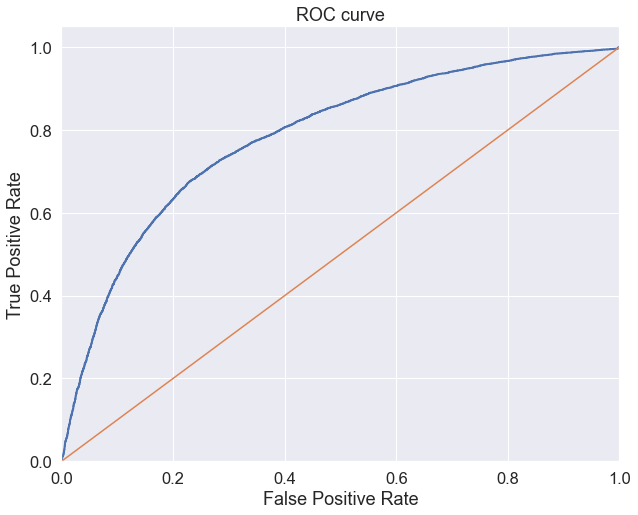

In [15]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [16]:
from sklearn.metrics import roc_auc_score, log_loss
    
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.7840355758278734
log loss score: 0.5779599355293669


Матрица ошибок

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


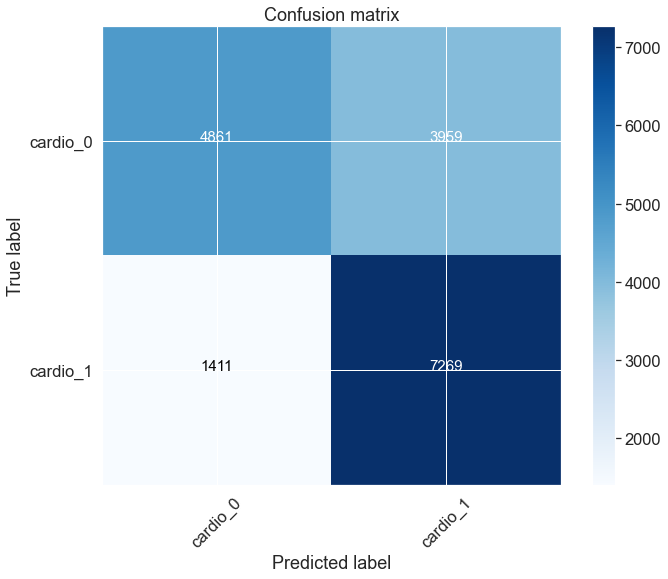

In [18]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [19]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.837442396313364, 0.44886621315192743, 0.5511337868480726)

In [20]:
###RandomForest

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
classifier = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(max_depth=2, random_state=0))])




In [22]:
#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))



CV score is 0.7841234124659306+-0.007387103233109082


In [23]:
#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('age',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='age')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('height',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='height')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('weight',
                                                 Pipeline(steps=[('selector',
                                        

In [24]:
X_test

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
10840,15505,15216,1,165,61,120,80,1,1,0,0,1
56267,80282,19815,1,164,54,110,80,1,1,0,0,1
14849,21224,20563,1,170,69,120,80,1,1,0,0,1
62726,89571,16625,1,167,57,110,70,1,1,0,0,1
47180,67392,14451,1,158,110,120,80,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
46143,65913,19616,1,165,63,120,80,2,2,0,0,0
5719,8133,21149,1,153,54,120,80,1,1,0,0,1
68531,97894,15972,2,172,64,110,70,1,1,0,0,1
15063,21541,18814,1,156,63,130,90,3,1,0,1,0


In [25]:
y_score = classifier.predict_proba(X_test)[:, 1]

Посчитаем precision/recall/f_score

In [26]:

b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.384142, F-Score=0.729, Precision=0.626, Recall=0.871


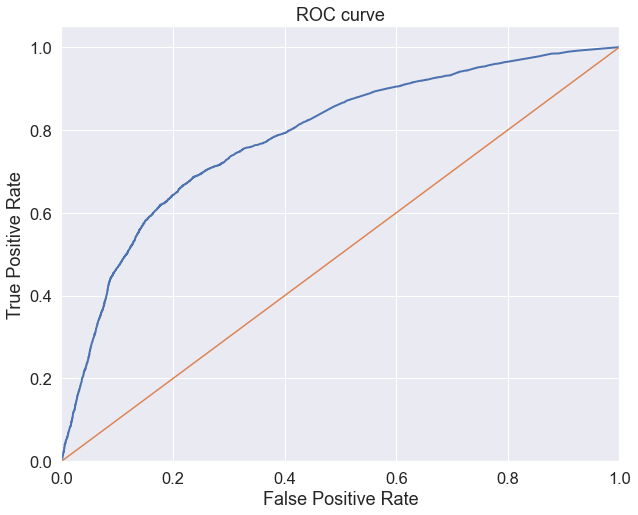

In [27]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()


In [28]:
from sklearn.metrics import roc_auc_score, log_loss
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))
#Ваш код здесь
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))


roc auc score: 0.7835594833171364
log loss score: 0.5917703539502256
roc auc score: 0.7835594833171364
log loss score: 0.5917703539502256


Матрица ошибок

Confusion matrix, without normalization
[[4306 4514]
 [1119 7561]]


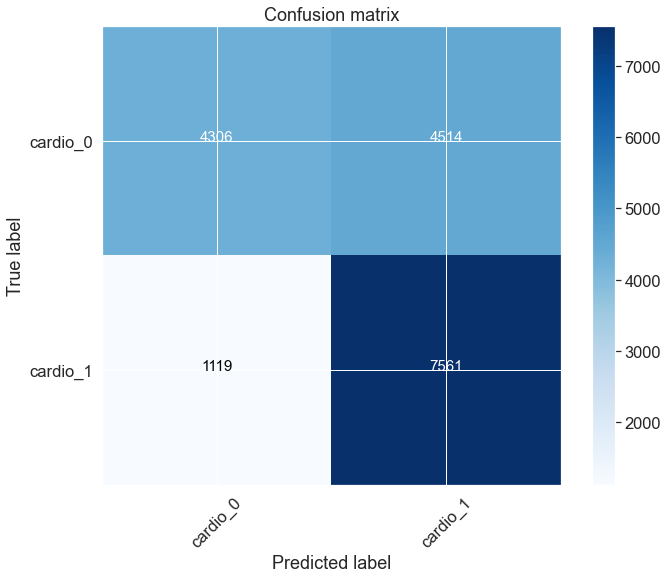

In [29]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [30]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.8710829493087557, 0.5117913832199547, 0.48820861678004535)

In [31]:
####XGBoost

In [32]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold


In [33]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
classifier = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBClassifier(random_state=21, use_label_encoder=False))])

In [34]:
#запустим кросс-валидацию
cv_scores = cross_val_score(classifier,  X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise' )
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

CV score is 0.7974949740373813+-0.005716565010685825


In [35]:
#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)

[20:52:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('age',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='age')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('height',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='height')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('weight',
                                                 Pipeline(steps=[('selector',
                                        

In [36]:
y_score = classifier.predict_proba(X_test)[:, 1]

Посчитаем precision/recall/f_score

In [37]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.349243, F-Score=0.738, Precision=0.666, Recall=0.828


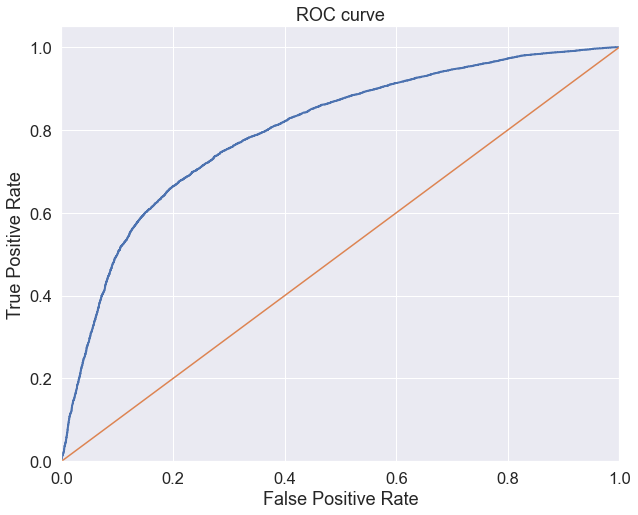

In [38]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [39]:
from sklearn.metrics import roc_auc_score, log_loss
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))
#Ваш код здесь
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.7984136388810517
log loss score: 0.5463538485086257
roc auc score: 0.7984136388810517
log loss score: 0.5463538485086257


Матрица ошибок

Confusion matrix, without normalization
[[5218 3602]
 [1491 7189]]


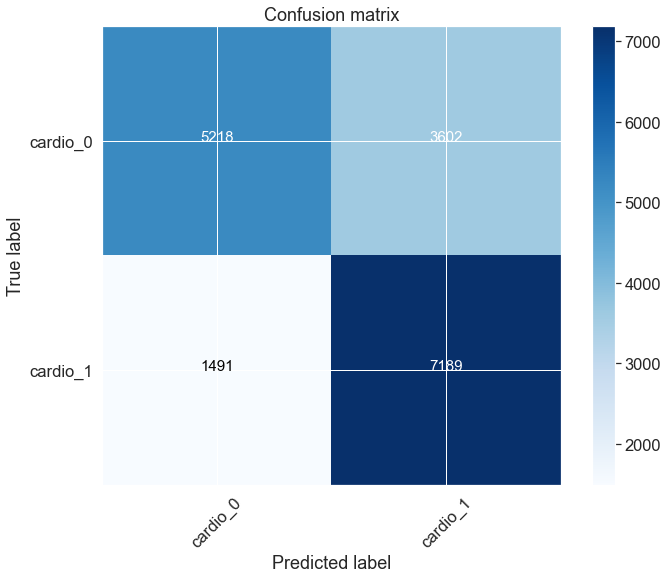

In [40]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [41]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.8282258064516129, 0.408390022675737, 0.591609977324263)

In [42]:
###KNeighborsClassifier()

In [43]:
from sklearn.neighbors import KNeighborsClassifier

In [44]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', KNeighborsClassifier())])


In [45]:
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

CV score is 0.6919734639047499+-0.007056151186699075


In [46]:
#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('age',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='age')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('height',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='height')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('weight',
                                                 Pipeline(steps=[('selector',
                                        

In [47]:
y_score = classifier.predict_proba(X_test)[:, 1]

Посчитаем precision/recall/f_score

In [48]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.400000, F-Score=0.686, Precision=0.588, Recall=0.822


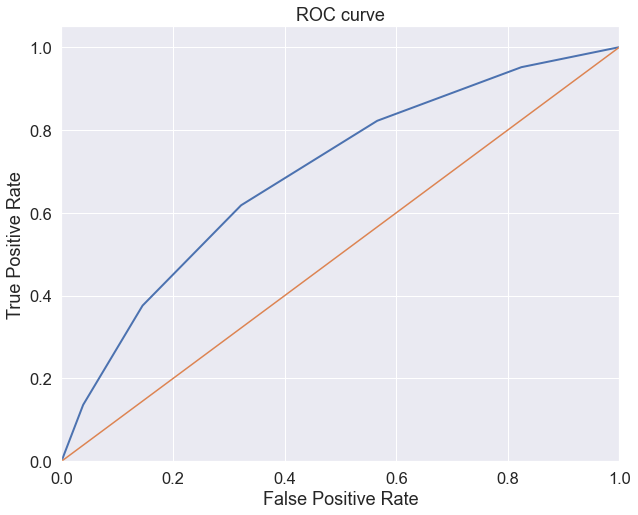

In [49]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [50]:
from sklearn.metrics import roc_auc_score, log_loss
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))
#Ваш код здесь
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.693992699614408
log loss score: 2.049644660796761
roc auc score: 0.693992699614408
log loss score: 2.049644660796761


Матрица ошибок

Confusion matrix, without normalization
[[5980 2840]
 [3314 5366]]


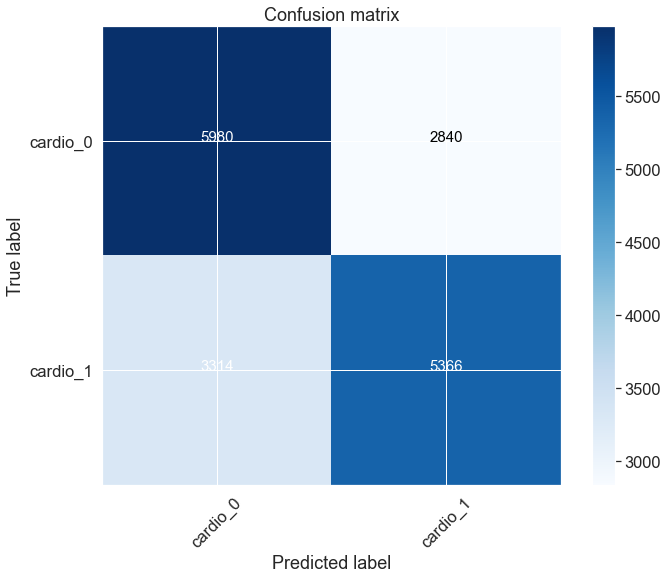

In [51]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}
plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [52]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.6182027649769585, 0.3219954648526077, 0.6780045351473923)

In [53]:
# random forest справился лучше других моделей

In [54]:
dfps = pd.DataFrame({'Модели': ['log_reg', 'Radom_forest', 'XGBoost', 'k-means neibours'], 'f-score': ['0.730', '0.729', '0.738', '0.686'], 'FPR': ['0.448', '0.510', '0.408', '0.321'], 'precision': ['0.647', '0.626', '0.666', '0.588'], 'recall': ['0.874', '0.871', '0.828', '0.822'], 'roc_auc_score' : ['0.784', '0.783', '0.798', '0.693']})
dfps

,Модели,f-score,FPR,precision,recall,roc_auc_score
0,log_reg,0.730,0.448,0.647,0.874,0.784
1,Radom_forest,0.729,0.510,0.626,0.871,0.783
2,XGBoost,0.738,0.408,0.666,0.828,0.798
3,k-means neibours,0.686,0.321,0.588,0.822,0.693


In [55]:
#№4#Считаю, что применить стоит модель с random forest, т.к она имеет наибольшее число ложно положительных результатов(FPR), что уменьшит вероятность пропустить пациента с заболеванием

In [56]:
#№5При дисбалансе классов больще подходит pr-кривая , т.к она auc кривая при высоком дисбалансе не будет учитываться размер выборки, и при некачественной модели roc-auc будет показывать васокий уроваень качества прогнозирования 

### Домашнее задание

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?